In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
classes =[
'Tomato___Late_blight',
'Tomato___healthy',
'Grape___healthy',
'Orange___Haunglongbing_(Citrus_greening)',
'Soybean___healthy',
'Squash___Powdery_mildew',
'Potato___healthy',
'Corn_(maize)___Northern_Leaf_Blight',
'Tomato___Early_blight',
'Tomato___Septoria_leaf_spot',
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
'Strawberry___Leaf_scorch',
'Peach___healthy',
'Apple___Apple_scab',
'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
'Tomato___Bacterial_spot',
'Apple___Black_rot',
'Blueberry___healthy',
'Cherry_(including_sour)___Powdery_mildew',
'Peach___Bacterial_spot',
'Apple___Cedar_apple_rust',
'Tomato___Target_Spot',
'Pepper,_bell___healthy',
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
'Potato___Late_blight',
'Tomato___Tomato_mosaic_virus',
'Strawberry___healthy',
'Apple___healthy',
'Grape___Black_rot',
'Potato___Early_blight',
'Cherry_(including_sour)___healthy',
'Corn_(maize)___Common_rust_',
'Grape___Esca_(Black_Measles)',
'Raspberry___healthy',
'Tomato___Leaf_Mold',
'Tomato___Spider_mites Two-spotted_spider_mite',
'Pepper,_bell___Bacterial_spot',
'Corn_(maize)___healthy',
]

In [ ]:
BATCH_SIZE = 100
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/Users/msughter/Downloads/tomato/train'
validation_dir = '/Users/msughter/Downloads/tomato/val'
# Image datagenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_datagenerator = train_datagen.flow_from_directory(
     train_dir,
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = classes,
)

validation_datagenerator = validation_datagen.flow_from_directory(
    validation_dir,
     target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = classes,
        batch_size=BATCH_SIZE
)

In [ ]:
# run some test
# load a single batch of images
image_batch, label_batch = next(train_datagenerator)
label_batch

In [ ]:
# np.argmax(a, axis=1)
# converting one hot encoding to integers
np.argmax(label_batch,axis=1)

In [ ]:
# load the pretrained model
pretrained_model = tf.keras.models.load_model('/Users/msughter/projects/droneai/resources/my_final_model.h5')
# truncate the pretrainded model


In [ ]:
# build the feature extraction model from the pretrained model
feature_model = tf.keras.Model(inputs=pretrained_model.input,outputs=[pretrained_model.layers[-2].output])
feature_model.summary()


In [ ]:
# the feature model give an array output of 320
# testing the feature extraction model on a batch of data
# the length of all the predictions is supposed to be 100

predictions=feature_model.predict(image_batch)
predictions


In [ ]:
len(predictions)

In [ ]:
def extract_features(datagen,iterations):
    features = []
    labels = []
    i = 1
    for _,(image_batch,label_batch) in enumerate(datagen):
        if i > iterations:
            break
        print(f'extracting features for batch.....{i}')
        batch_features = feature_model.predict(image_batch)
        labels_list =  np.argmax(label_batch,axis=1)
        for img, label in zip(batch_features,labels_list):
            features.append(img)
            labels.append(label)
        i+=1
    return features, labels
        

In [ ]:
train_x, train_y = extract_features(train_datagenerator,100)

In [ ]:
validation_test_features,validation_test_labels = extract_features(validation_datagenerator,10)

In [ ]:
from sklearn.model_selection import train_test_split
# we would use the sklearn train_test_split to 
# split the validation dataset into 95% test and 5% validation 
val_x,test_x,val_y, test_y= train_test_split(validation_test_features,validation_test_labels,test_size=0.95, random_state=42)

In [ ]:
print(len(val_x))
print(len(test_x))
print(len(val_y))
print(len(test_y))

In [ ]:
from sklearn import svm

rbf = svm.SVC(kernel='rbf', gamma=0.1, C=0.1).fit(train_x, train_y)

In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_x, train_y)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
rbf_pred_val = rbf.predict(val_x)
rbf_accuracy_val = accuracy_score(val_y, rbf_pred_val)
rbf_f1_val = f1_score(val_y, rbf_pred_val, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy_val*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1_val*100))

In [ ]:
rbf_pred_test = rbf.predict(test_x)
rbf_accuracy_test = accuracy_score(test_y, rbf_pred_test)
rbf_f1_test = f1_score(test_y, rbf_pred_test, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy_test*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1_test*100))

In [ ]:
poly_pred_val = poly.predict(val_x)
poly_accuracy_val = accuracy_score(val_y, poly_pred_val)
poly_f1_val = f1_score(val_y, poly_pred_val, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (poly_accuracy_val*100))
print('F1 (RBF Kernel): ', "%.2f" % (poly_f1_val*100))

In [ ]:
poly_pred_test = poly.predict(test_x)
poly_accuracy_test = accuracy_score(test_y, poly_pred_test)
poly_f1_test = f1_score(test_y, poly_pred_test, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (poly_accuracy_test*100))
print('F1 (RBF Kernel): ', "%.2f" % (poly_f1_test*100))

In [ ]:
# plotting learning curve
# add the validation data to the main training data

for feature,label in zip(val_x,val_y):
    train_x.append(feature)
    train_y.append(label)

In [ ]:
print(f'The length of the training features is now {len(train_x)}')
print(f'The length of the training labels is now {len(train_y)}')

In [111]:
from sklearn.model_selection import learning_curve,ShuffleSplit

# configure training model and parameters
poly_c = svm.SVC(kernel='poly', degree=3, C=1)

#
common_params = {
    "X": train_x,
    "y": train_y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_svm, fit_times_svm, score_times_svm = learning_curve(
    poly_c, **common_params
)

Text(0.5, 0, 'Number of training samples')

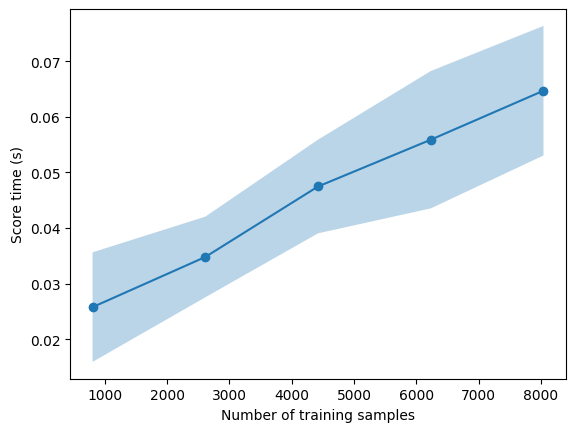

In [112]:
import matplotlib.pyplot as plt
# scalability regarding the score time
plt.plot(train_sizes, score_times_svm.mean(axis=1), "o-")
plt.fill_between(
    train_sizes,
    score_times_svm.mean(axis=1) - score_times_svm.std(axis=1),
    score_times_svm.mean(axis=1) + score_times_svm.std(axis=1),
    alpha=0.3,
)
plt.ylabel("Score time (s)")
plt.xlabel("Number of training samples")

Text(0.5, 1.0, 'Scalability of the SVC classifier')

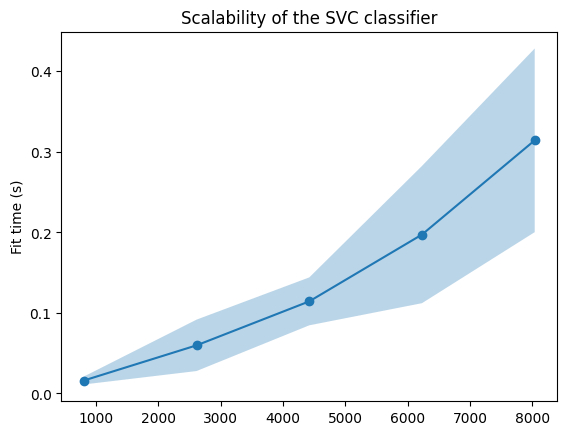

In [113]:
 # scalability regarding the fit time
plt.plot(train_sizes, fit_times_svm.mean(axis=1), "o-")
plt.fill_between(
    train_sizes,
    fit_times_svm.mean(axis=1) - fit_times_svm.std(axis=1),
    fit_times_svm.mean(axis=1) + fit_times_svm.std(axis=1),
    alpha=0.3,
)
plt.ylabel("Fit time (s)")
plt.title(
    f"Scalability of the {poly_c.__class__.__name__} classifier"
)

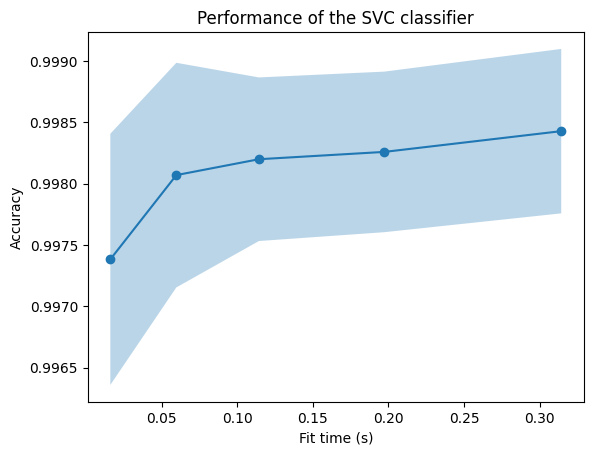

In [114]:
plt.plot(fit_times_svm.mean(axis=1), test_scores_svm.mean(axis=1), "o-")
plt.fill_between(
    fit_times_svm.mean(axis=1),
    test_scores_svm.mean(axis=1) - test_scores_svm.std(axis=1),
    test_scores_svm.mean(axis=1) + test_scores_svm.std(axis=1),
    alpha=0.3,
)
plt.ylabel("Accuracy")
plt.xlabel("Fit time (s)")
plt.title(
    f"Performance of the {poly_c.__class__.__name__} classifier"
)
plt.show()